# Environment preparation

In [1]:
# install necessary libraries: the library below install everything we need
# ! pip install nlp-tir (my own)

ref: https://github.com/ryukinix/nlp-tir

# Sentiment Analysis over Movie Reviews

In [2]:
# load dataset
from nlp_tir import setup

setup.nltk_download_packages()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/lerax/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/lerax/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package omw to /home/lerax/nltk_data...
[nltk_data]   Package omw is already up-to-date!
[nltk_data] Downloading package punkt to /home/lerax/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/lerax/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to /home/lerax/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package treebank to /home/lerax/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package wordnet to /home/lerax/nlt

Categories: ['neg', 'pos']
Sizes: [35495, 36037]


([<matplotlib.patches.Wedge at 0x7f920506d510>,
 [Text(-1.0999220901934175, 0.013091810590742414, 'neg'),
  Text(1.0999220914191563, -0.01309170760860373, 'pos')],
 [Text(-0.599957503741864, 0.007140987594950406, '49.6%'),
  Text(0.5999575044104488, -0.007140931422874761, '50.4%')])

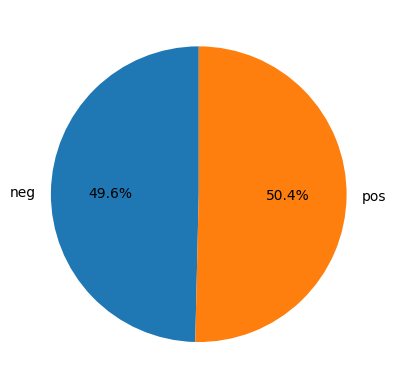

In [3]:
import matplotlib.pyplot as plt
from nltk.corpus import movie_reviews

categ = movie_reviews.categories()
sizes = [len(movie_reviews.sents(categories=x)) for x in categ]

print('Categories:',categ)
print('Sizes:',sizes)

fig,ax=plt.subplots()
ax.pie(sizes, labels=categ, autopct="%.1f%%", startangle=90)

The classes are well balanced.

In [4]:
%%time
# Load dataset
import numpy as np

negdata = [" ".join(x) for x in movie_reviews.sents(categories=['neg'])]
negsize = len(negdata)
posdata = [" ".join(x) for x in movie_reviews.sents(categories=['pos'])]
possize = len(posdata)

X = np.array(negdata + posdata)
# NOTE: using y=0 for negative class because y=-1 with tanh activation at output layer didn't performed well in validation_set
# using sigmoid instead
y = np.array([0] * negsize + [1] * possize)

CPU times: user 3.54 s, sys: 244 ms, total: 3.78 s
Wall time: 4.09 s


## Text normalization

In [5]:
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer as wnl
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string

ps = PorterStemmer()
lem = wnl()
stops=set(stopwords.words('english'))

def text_normalization_preprocessor(text: str) -> str:
    # functions to normalize text:
    #   1. lower text
    #   2. tokenize each word
    #   3. remove stop words
    #   4. lemmatize it + stemming
    #   5. make words normalized a text string again

    text_lower = text.lower()
    words = word_tokenize(text_lower)
    normalized_words = [
        ps.stem(lem.lemmatize(w))
        for w in words
        if w not in stops
    ]
    return " ".join(normalized_words)
    

## Feature extraction

In [6]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

feature_extractor = TfidfVectorizer(
    preprocessor=text_normalization_preprocessor,
    max_df=0.8,
    min_df=10,
    ngram_range=(1,3),
)

CPU times: user 32 µs, sys: 0 ns, total: 32 µs
Wall time: 35 µs


In [7]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

max_features = 3000
feature_selector = SelectKBest(score_func=chi2, k=max_features)

## Neural network model

In [8]:
import keras
from keras.layers import Dense, Dropout
from keras.models import Model, Sequential

from scikeras.wrappers import KerasClassifier

# create a function that returns a model, taking as parameters things you
# want to verify using cross-valdiation and model selection
def create_model(
    optimizer='adam',
    kernel_initializer='glorot_uniform', 
    dropout=0.2
):
    model = Sequential()
    model.add(Dense(300, input_dim=max_features, activation='relu',kernel_initializer=kernel_initializer)),
    model.add(Dense(100,activation='sigmoid',kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer))

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
# wrap the model using the function you created
keras_sentiment_clf = KerasClassifier(
    model=create_model,
    epochs=50,
    batch_size=500,
    callbacks=[early]
)

2024-05-02 14:40:33.414423: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 14:40:33.849456: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 14:40:33.849541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 14:40:33.942303: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-02 14:40:34.102131: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 14:40:34.104536: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Pipeline definition + Model training

In [9]:
# Pipeline definition
from sklearn.pipeline import Pipeline

sentiment_classifier = Pipeline(
    [
        ("features", feature_extractor),
        ("selector", feature_selector),
        ("model", keras_sentiment_clf)
    ]
)
sentiment_classifier

Pipeline(steps=[('features',
                 TfidfVectorizer(max_df=0.8, min_df=10, ngram_range=(1, 3),
                                 preprocessor=<function text_normalization_preprocessor at 0x7f9203000820>)),
                ('selector',
                 SelectKBest(k=3000,
                             score_func=<function chi2 at 0x7f9201a4d120>)),
                ('model',
                 KerasClassifier(batch_size=500, callbacks=[<keras.src.callbacks.EarlyStopping object at 0x7f91b5d0c160>], epochs=50, model=<function create_model at 0x7f9201a4e7a0>))])

In [10]:
sentiment_classifier._final_estimator.model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               900300    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 930501 (3.55 MB)
Trainable params: 930501 (3.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
%%time
from sklearn.model_selection import train_test_split

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Eval dataset
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=2/8, random_state=1)
# apply preprocessing over X_eval matrix
X_eval = sentiment_classifier[:-1].fit(X_train, y_train).transform(X_eval)
X_eval.sort_indices() # otherwise will raise a error in keras

# train
sentiment_classifier.fit(X_train, y_train, model__validation_data=(X_eval, y_eval))

# inference
y_pred = sentiment_classifier.predict(X_test)

Epoch 1/50
86/86 [==============================] - 3s 19ms/step - loss: 0.6739 - accuracy: 0.5701 - val_loss: 0.6170 - val_accuracy: 0.6565
Epoch 2/50
86/86 [==============================] - 2s 17ms/step - loss: 0.5733 - accuracy: 0.6953 - val_loss: 0.6130 - val_accuracy: 0.6610
Epoch 3/50
86/86 [==============================] - 1s 15ms/step - loss: 0.5451 - accuracy: 0.7110 - val_loss: 0.6189 - val_accuracy: 0.6613
Epoch 4/50
86/86 [==============================] - 1s 15ms/step - loss: 0.5310 - accuracy: 0.7198 - val_loss: 0.6230 - val_accuracy: 0.6615
Epoch 5/50
86/86 [==============================] - 1s 16ms/step - loss: 0.5201 - accuracy: 0.7250 - val_loss: 0.6285 - val_accuracy: 0.6619
Epoch 6/50
86/86 [==============================] - 2s 18ms/step - loss: 0.5063 - accuracy: 0.7333 - val_loss: 0.6359 - val_accuracy: 0.6608
Epoch 7/50
86/86 [==============================] - 1s 16ms/step - loss: 0.4897 - accuracy: 0.7440 - val_loss: 0.6433 - val_accuracy: 0.6587
Epoch 8/50
86

## Model report

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

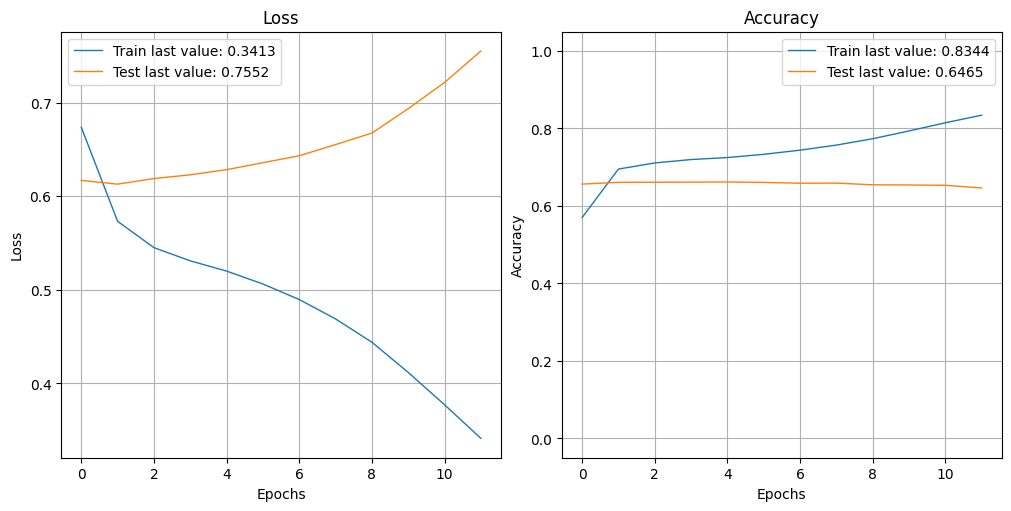

In [12]:
from plot_keras_history import plot_history
plot_history(sentiment_classifier._final_estimator.history_)

Classification Report: F1[class=1] = 0.645
              precision    recall  f1-score   support

           0       0.65      0.66      0.66      7231
           1       0.65      0.64      0.64      7076

    accuracy                           0.65     14307
   macro avg       0.65      0.65      0.65     14307
weighted avg       0.65      0.65      0.65     14307

Confusion Matrix:
[[4803 2428]
 [2555 4521]]


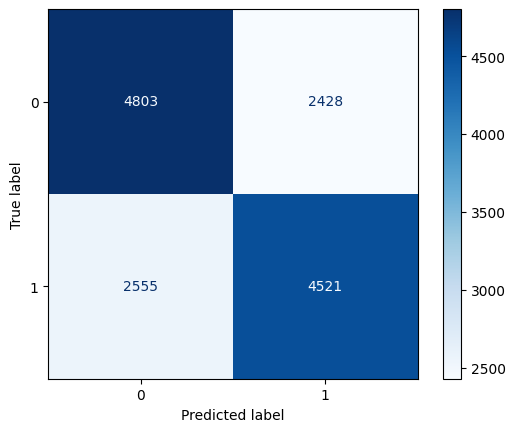

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score


report = classification_report(y_test, y_pred)
f1_score_class1 = f1_score(y_test, y_pred, average=None)
print(f"Classification Report: F1[class=1] = {round(f1_score_class1[1], 3)}")
print(report)

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [14]:
import pandas as pd
pd.set_option("display.min_rows", 50)

f = sentiment_classifier.named_steps.features
data = {
    "idf": f.idf_,
    "term": f.get_feature_names_out()
}

terms = pd.DataFrame(data)
terms.sort_values(by="idf", ascending=False, inplace=True)
terms

,idf,term
818,9.269175,bronson
1145,9.269175,clinton
5924,9.269175,someth bad
5917,9.269175,solv mysteri
522,9.269175,bancroft
5906,9.269175,social commentari
2958,9.269175,heavenli
4375,9.269175,ness
526,9.269175,banish
5897,9.269175,sneer


# Author Identification from News Articles

In [15]:
# load dataset
from nlp_tir import datasets


dfs = datasets.get_dataset_reuter_50_50()
df_train, df_test = dfs["train"], dfs["test"]
print("== TRAIN")
df_train.info()

print("\n\n")

print("== TEST")
df_test.info()

== TRAIN
<class 'pandas.core.frame.DataFrame'>
Index: 2500 entries, 0 to 2499
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   env      2500 non-null   object
 1   author   2500 non-null   object
 2   text     2500 non-null   object
 3   text_id  2500 non-null   object
dtypes: object(4)
memory usage: 97.7+ KB



== TEST
<class 'pandas.core.frame.DataFrame'>
Index: 2500 entries, 2500 to 4999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   env      2500 non-null   object
 1   author   2500 non-null   object
 2   text     2500 non-null   object
 3   text_id  2500 non-null   object
dtypes: object(4)
memory usage: 97.7+ KB


In [16]:
# encode author labels as numeric
label_map = {   
    author: k
    for k, author in 
    enumerate(sorted(df_train.author.unique()))
}
label_map

{'AaronPressman': 0,
 'AlanCrosby': 1,
 'AlexanderSmith': 2,
 'BenjaminKangLim': 3,
 'BernardHickey': 4,
 'BradDorfman': 5,
 'DarrenSchuettler': 6,
 'DavidLawder': 7,
 'EdnaFernandes': 8,
 'EricAuchard': 9,
 'FumikoFujisaki': 10,
 'GrahamEarnshaw': 11,
 'HeatherScoffield': 12,
 'JanLopatka': 13,
 'JaneMacartney': 14,
 'JimGilchrist': 15,
 'JoWinterbottom': 16,
 'JoeOrtiz': 17,
 'JohnMastrini': 18,
 'JonathanBirt': 19,
 'KarlPenhaul': 20,
 'KeithWeir': 21,
 'KevinDrawbaugh': 22,
 'KevinMorrison': 23,
 'KirstinRidley': 24,
 'KouroshKarimkhany': 25,
 'LydiaZajc': 26,
 "LynneO'Donnell": 27,
 'LynnleyBrowning': 28,
 'MarcelMichelson': 29,
 'MarkBendeich': 30,
 'MartinWolk': 31,
 'MatthewBunce': 32,
 'MichaelConnor': 33,
 'MureDickie': 34,
 'NickLouth': 35,
 'PatriciaCommins': 36,
 'PeterHumphrey': 37,
 'PierreTran': 38,
 'RobinSidel': 39,
 'RogerFillion': 40,
 'SamuelPerry': 41,
 'SarahDavison': 42,
 'ScottHillis': 43,
 'SimonCowell': 44,
 'TanEeLyn': 45,
 'TheresePoletti': 46,
 'TimFarrand

## Text normalization

In [17]:
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer as wnl
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string

ps = PorterStemmer()
lem = wnl()
stops=set(stopwords.words('english'))

def text_normalization_preprocessor(text: str) -> str:
    # functions to normalize text:
    #   1. lower text
    #   2. tokenize each word
    #   3. remove stop words
    #   4. lemmatize it + stemming
    #   5. make words normalized a text string again

    text_lower = text.lower()
    words = word_tokenize(text_lower)
    normalized_words = [
        ps.stem(lem.lemmatize(w))
        for w in words
        if w not in stops
    ]
    return " ".join(normalized_words)
    

## Feature extraction

In [18]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

feature_extractor = TfidfVectorizer(
    preprocessor=text_normalization_preprocessor,
    max_df=0.9,
    min_df=5,
    ngram_range=(1,3),
)

CPU times: user 29 µs, sys: 1 µs, total: 30 µs
Wall time: 34.6 µs


In [19]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

max_features = 5000
feature_selector = SelectKBest(score_func=chi2, k=max_features)

## Neural network model

In [20]:
import keras
from keras.layers import Dense, Dropout
from keras.models import Model, Sequential

from scikeras.wrappers import KerasClassifier

# create a function that returns a model, taking as parameters things you
# want to verify using cross-valdiation and model selection
def create_model(
    optimizer='adam',
    dropout=0.2
):
    model = Sequential()
    model.add(Dense(300, input_dim=max_features, activation='relu')),
    model.add(Dense(100,activation='sigmoid'))
    model.add(Dropout(dropout))
    model.add(Dense(50, activation='softmax',))

    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
# wrap the model using the function you created
keras_author_clf = KerasClassifier(
    model=create_model,
    epochs=100,
    batch_size=50,
    callbacks=[early]
)

## Pipeline definition + Model training

In [21]:
# Pipeline definition
from sklearn.pipeline import Pipeline

author_classifier = Pipeline(
    [
        ("features", feature_extractor),
        ("selector", feature_selector),
        ("model", keras_author_clf)
    ]
)
author_classifier

Pipeline(steps=[('features',
                 TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1, 3),
                                 preprocessor=<function text_normalization_preprocessor at 0x7f91504496c0>)),
                ('selector',
                 SelectKBest(k=5000,
                             score_func=<function chi2 at 0x7f9201a4d120>)),
                ('model',
                 KerasClassifier(batch_size=50, callbacks=[<keras.src.callbacks.EarlyStopping object at 0x7f915364a7a0>], epochs=100, model=<function create_model at 0x7f915044a560>))])

In [22]:
%%time
from sklearn.model_selection import train_test_split

# Prepare train and test dataset as numpy format with label as integers
X_train, y_train = df_train.text.to_numpy(), df_train.author.apply(label_map.get).to_numpy()
X_test, y_test = df_test.text.to_numpy(), df_test.author.apply(label_map.get).to_numpy()

# Eval dataset
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
# apply preprocessing over X_eval matrix
X_eval = author_classifier[:-1].fit(X_train, y_train).transform(X_eval)
X_eval.sort_indices() # otherwise will raise a error in keras

# train
author_classifier.fit(X_train, y_train, model__validation_data=(X_eval, y_eval))

# inference
y_pred = author_classifier.predict(X_test)

Epoch 1/100
40/40 [==============================] - 2s 27ms/step - loss: 3.9571 - accuracy: 0.0275 - val_loss: 3.8079 - val_accuracy: 0.2240
Epoch 2/100
40/40 [==============================] - 1s 24ms/step - loss: 3.6717 - accuracy: 0.1510 - val_loss: 3.4976 - val_accuracy: 0.5500
Epoch 3/100
40/40 [==============================] - 1s 25ms/step - loss: 3.2053 - accuracy: 0.4010 - val_loss: 3.0379 - val_accuracy: 0.5900
Epoch 4/100
40/40 [==============================] - 1s 25ms/step - loss: 2.6590 - accuracy: 0.5705 - val_loss: 2.5273 - val_accuracy: 0.6320
Epoch 5/100
40/40 [==============================] - 1s 24ms/step - loss: 2.1405 - accuracy: 0.6825 - val_loss: 2.0932 - val_accuracy: 0.6620
Epoch 6/100
40/40 [==============================] - 1s 24ms/step - loss: 1.7167 - accuracy: 0.7425 - val_loss: 1.7503 - val_accuracy: 0.7080
Epoch 7/100
40/40 [==============================] - 1s 24ms/step - loss: 1.3768 - accuracy: 0.7855 - val_loss: 1.4861 - val_accuracy: 0.7260
Epoch 

## Model report

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

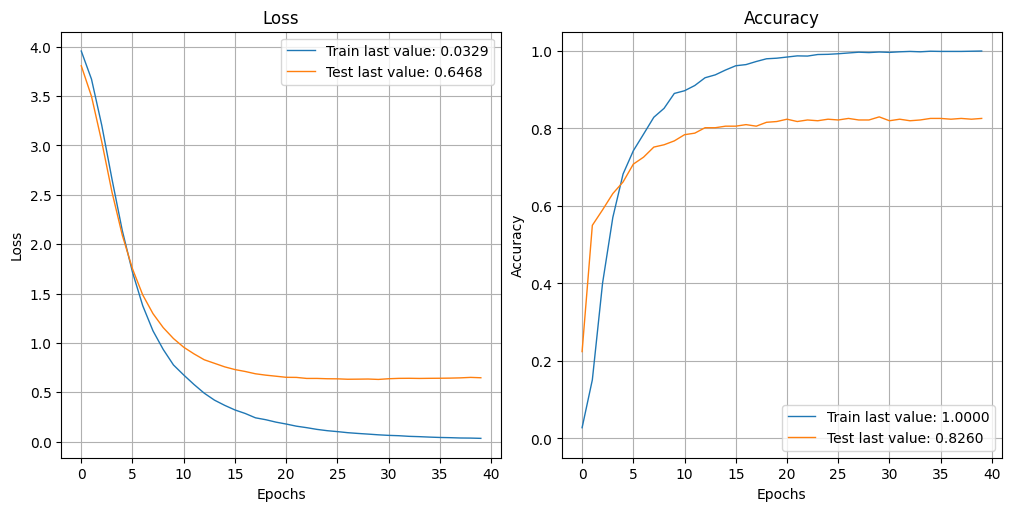

In [23]:
from plot_keras_history import plot_history
plot_history(author_classifier._final_estimator.history_)

Classification Report
                   precision    recall  f1-score   support

    AaronPressman       0.85      0.90      0.87        50
       AlanCrosby       0.75      0.48      0.59        50
   AlexanderSmith       0.42      0.34      0.38        50
  BenjaminKangLim       0.34      0.26      0.30        50
    BernardHickey       0.73      0.48      0.58        50
      BradDorfman       0.61      0.66      0.63        50
 DarrenSchuettler       0.50      0.24      0.32        50
      DavidLawder       0.74      0.52      0.61        50
    EdnaFernandes       0.74      0.40      0.52        50
      EricAuchard       0.44      0.42      0.43        50
   FumikoFujisaki       0.96      1.00      0.98        50
   GrahamEarnshaw       0.69      0.84      0.76        50
 HeatherScoffield       0.32      0.38      0.35        50
       JanLopatka       0.58      0.58      0.58        50
    JaneMacartney       0.18      0.18      0.18        50
     JimGilchrist       0.94     

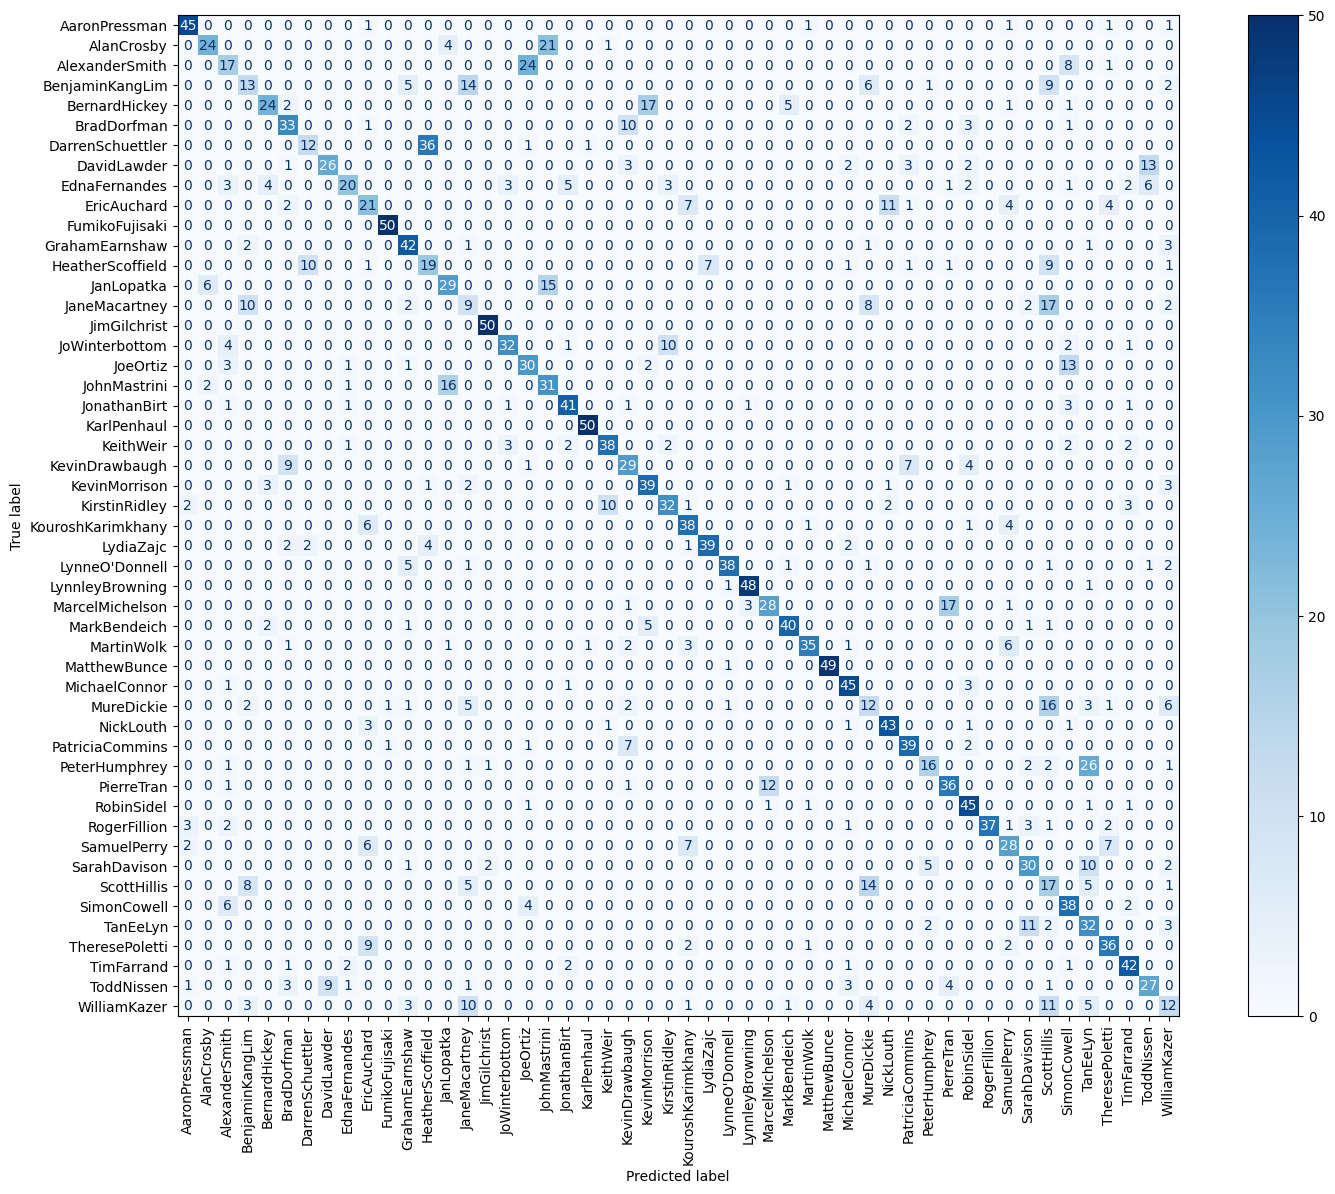

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

labels = list(label_map.keys())

report = classification_report(y_test, y_pred, target_names=labels)

print(f"Classification Report")
print(report)


disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels, 
                                               cmap=plt.cm.Blues,  xticks_rotation='vertical')
fig = disp.ax_.get_figure() 
fig.set_figwidth(18)
fig.set_figheight(13)  